In [2]:
import csv
import numpy as np

filename=input('input filename: ')

def read_csv():
    with open(filename,'rt',encoding='UTF-8') as f:
        readers=csv.reader(f,delimiter=';')
        x=list(readers)
        rd=np.array(x)
        
    return(rd)
   

input filename: FMC10MHz_plate2_tb_50deg22mm2.txt


In [2]:
#input 

# nome=string('FMC10MHz_plate2_tb_50deg22mm2')
N=64  #number of elements
a=0.0002  # m, element width
pitch=0.0003  # m, pitch 
fa=100e6 # Hz, sampling frequency
delay=23e-6 # s,
f0=10e6   #Hz, central excitation frequency
c1=1480   # m/s, Longitudinal velocity (water or wedge)
c2=5800   # m/s, Longitudinal velocity (steel)
ncr=3
# anginc=10.8*pi/180;   # rad, incidence angle.
#zaN=0.020*cos(anginc)   # m, distance between interface and centre of the 
# phased array transducer. The distance is measured perpendicular to the interface



In [3]:
import math
import xacalc
import TFMimage
import TOF
import TOF2
import FMCdata
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pdb
import warnings
warnings.filterwarnings('ignore')
#def fxn():
    #warnings.warn("deprecated", DeprecationWarning)

#with warnings.catch_warnings():
   # warnings.simplefilter("ignore")
    #fxn()
    

# Input:
# xx -> x coordinate of the centre of the transducer
# zx -> z coordinate of the centre of the transducer
# za -> z coordinate of the interface (hight of the wedge)
# xp -> x coordinate of the focusing point
# c1 -> sound speed, medium 1
# c2 -> sound speed, medium 2
# deriv -> derivative of the line that characterize the interface

#Output:
# xa -> x coordinate of the interface
# zac -> z coordinate of the interface
# Iones -> matrix where 1 means the point is below the interface (inside the 
# test sample) and 0 means the point is at the interface or above it

class TFM:
    def __init__(self,N,f0,fa,delay,ncr,rd,c1,c2,pitch):
        self.N=N
        self.f0=f0
        self.fa=fa
        self.delay=delay
        self.ncr=ncr
        self.rd=rd
        self.c1=c1
        self.c2=c2
        self.pitch=pitch
      
   
          
    def array_position(self):
       
        sarray=(self.N-1)*self.pitch    #size of array
        self.xt=np.arange(-sarray/2,sarray/2+self.pitch,self.pitch)  # 左开右闭原则，比matlab少一个元素所以再加一个pitch
        self.zt=-0.001*np.ones((self.N))
        
        #self.xt=array*np.cos(self.anginc)
    
        #self.zt=array*np.sin(self.anginc)
        #ztred=zt
        return (self.xt,self.zt)
        #zt=np.zeros((N,1),dtype=float) 
        
        
    def grid_position(self):
        self.XPmin=-0.01 # 0.02659 19 m, minimal coordinate of x axis to focus 
        self.XPmax=0.036 # 0.03657 27 m, maximal coordinate of x axis to focus 
        self.ZPmin=0.0  # 0.032 m, minimal coordinate of z axis to focus 
        self.ZPmax=0.13 # 0.040 m, maximal coordinate of z axis to focus
        self.resolution=0.0002 # 0.0001 m, grid resolution

        self.Gx=np.arange(self.XPmin,self.XPmax+self.resolution,self.resolution)
        self.Gz=np.arange(self.ZPmin,self.ZPmax+self.resolution,self.resolution)
     
        return(self.Gx,self.Gz)
    
    
    def pa_blocs(self):
        nblocs=8
        nsize=np.zeros((nblocs,1),dtype=int)
        nsize[:,0]=np.floor(self.N/nblocs)
       
                            
        dimension2=np.arange(1,nblocs+1)
        dimension2=dimension2.reshape(dimension2.shape[0],1)

        self.nbmax=nsize*dimension2
        self.nbmax[nblocs-1]=np.sum(nsize)
        self.nbmin=self.nbmax-(nsize[:]-1)
        
        return(self.nbmax,self.nbmin)
    
    
    def xac(self):
        nblocs=8     #divide phased array probes to 8 sections
        
        #import class method and variables
        
        self.pa_blocs()
        self.array_position()
        self.grid_position()
        
        self.za=0.001
        
        self.xaa=np.zeros((self.Gx.size,self.Gz.size,self.xt.size))
        self.zaa=np.zeros((self.Gx.size,self.Gz.size,self.xt.size))
       
        for bloco in range(nblocs):
           
            xx=self.xt[self.nbmin[bloco,0]-1:self.nbmax[bloco,0]]
            zx=self.zt[self.nbmin[bloco,0]-1:self.nbmax[bloco,0]]
            
            #import xacalc function to calcuate xaa,zaa
            xap,zap=xacalc.polynomial_equation(self.za,self.c1,self.c2,xx,zx)

            self.xaa[:,:,self.nbmin[bloco,0]-1:self.nbmax[bloco,0]]= xap
            self.zaa[:,:,self.nbmin[bloco,0]-1:self.nbmax[bloco,0]]= zap
            
            #self.xaa=np.array(self.xaa)
            #self.zaa=np.array(self.zaa)
        
        #self.za=za*np.ones((self.xa.shape,1))
        return(self.xaa,self.zaa,self.za)
    
    
    def grid_partition(self):
        XPmin=-0.01 # 0.02659 19 m, minimal coordinate of x axis to focus 
        XPmax=0.036 # 0.03657 27 m, maximal coordinate of x axis to focus 
        resolution=0.0002 # 0.0001 m, grid resolution
        
        self.grid_position()

        partes=16    #number of blocks
        
        xsize=np.zeros((partes-1,1),dtype=int)
        xsize[:,0]=np.floor(self.Gx.shape[0]/partes)
        remainder=self.Gx.shape[0]%partes+np.floor(self.Gx.shape[0]/partes)

        xsize=np.vstack((xsize,remainder))
        
        partes=xsize.size 
        
        dimension=np.arange(1,partes+1)
        dimension=dimension.reshape(dimension.shape[0],1)  #一维数组行列转换
        
        self.xpmax=np.squeeze(XPmin-resolution+(xsize*resolution*dimension))
        self.xpmax[partes-1]=XPmax
        self.xpmin=self.xpmax-(xsize[:,0]-1)*resolution
        
        
        self.nxpmax=np.squeeze(xsize*dimension)
        self.nxpmax[partes-1]=np.sum(xsize)
        self.nxpmin=self.nxpmax-(xsize[:,0]-1)
        
        self.partes=partes
        
        return(self.xpmin,self.xpmax,self.nxpmax,self.nxpmin,self.partes)
    
    
    def TFM_function(self):
        
        self.grid_partition()
        self.grid_position()
        self.xac()
        self.array_position()
        
        resolution=0.0002 # 0.0001 m, grid resolution
        FMCh=FMCdata.FMC(self.N,self.f0,self.fa,self.delay,self.ncr,self.rd)
        
        Gxsize=int(np.floor(self.Gx.size/self.partes))  #only integer can be used in np.empty
        
        I=np.empty((self.Gx.size,self.Gz.size))  #create initial empty array for TFM
        
        
        for parte in range(self.partes-1):
            #gx=np.arange(self.xpmin[parte],self.xpmax[parte]+resolution,resolution)
     
            xap=self.xaa[int(self.nxpmin[parte])-1:int(self.nxpmax[parte]),:,:]  
            zap=self.zaa[int(self.nxpmin[parte])-1:int(self.nxpmax[parte]),:,:]
        
            temp=TOF.Time_of_flight(self.xpmin[parte],self.xpmax[parte],xap,self.N,self.pitch,self.za,self.c1,self.c2)
        
            
            Ip=TFMimage.amplitude(temp,self.fa,FMCh,self.N)
            
            I[int(self.nxpmin[parte])-1:int(self.nxpmax[parte]),:]=Ip
            
        
        xap=self.xaa[int(self.nxpmin[self.partes-1])-1:int(self.nxpmax[self.partes-1]),:,:]  
        zap=self.zaa[int(self.nxpmin[self.partes-1])-1:int(self.nxpmax[self.partes-1]),:,:]
        
        temp2=TOF2.Time_of_flight(self.xpmin[self.partes-1],self.xpmax[self.partes-1],
                                 xap,self.N,self.pitch,self.za,self.c1,self.c2)
        Ip2=TFMimage.amplitude(temp2,self.fa,FMCh,self.N)
        I[int(self.nxpmin[self.partes-1])-1:int(self.nxpmax[self.partes-1]),:]=Ip2
        
        
        
        
            
        
        pdb.set_trace()
        #TFM images
        Iabs=np.abs(I)
        Iabs2=Iabs/(np.max(Iabs))
        
        imag=interpolate.interp2d(self.Gx,self.Gz,Iabs4,kind='cubic')
        
        #Iabsdb=20*np.log(Iabs4)
        #Iabsdb=np.choose(Iabsdb<-60,(Iabsdb,-60))
        
        
        im2=plt.imshow(Iabs4, extent=[1000*self.XPmin,1000*self.XPmax,1000*self.ZPmin,1000*self.ZPmax], 
                       cmap='viridis', interpolation='bicubic', origin="lower")
        plt.colorbar(im2)
        plt.show()

  

     

                  

input filename: FMC10MHz_plate2_tb_50deg22mm2.txt


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


> <ipython-input-3-b876b8f0a4b5>(204)TFM_function()
-> Iabs=np.abs(I)
(Pdb) c


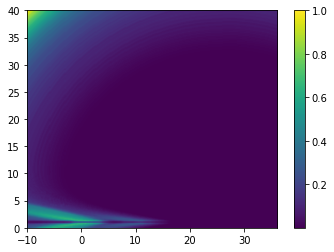

In [4]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


rd=read_csv()
trial= TFM(N=32,f0=5e6,fa=100e6,delay=0,ncr=0,rd=rd,c1=1480,c2=5800,pitch=0.0003)

trial.TFM_function()

In [2]:
import numpy as np

a=np.array([1,2,3])
c=np.array([1,2,3,4])
b=[]
for element in a:
    b.append(c[element])
b

[2, 3, 4]